In [41]:
from hyperopt import fmin, tpe, hp, STATUS_OK, STATUS_FAIL, Trials, base
from hyperopt.plotting import *
import numpy as np
import math
import time
import logging
from data.data_loader import Dataset
from data.germeval2017 import germeval2017_dataset
from misc.preferences import PREFERENCES
from misc.run_configuration import from_hyperopt, OutputLayerType, LearningSchedulerType, OptimizerType
from misc import utils
from misc.hyperopt_space import *

from optimizer import get_optimizer
from criterion import NllLoss, LossCombiner

from models.transformer.encoder import TransformerEncoder
from models.jointAspectTagger import JointAspectTagger
from trainer.train import Trainer
import pprint

# Loading Functions

These functions will load the dataset and the model. The run configuration will determine the architecture and hyper parameters.

In [33]:
def load_model(dataset, rc, experiment_name):
    loss = LossCombiner(4, dataset.class_weights, NllLoss)
    transformer = TransformerEncoder(dataset.source_embedding,
                                     hyperparameters=rc)
    model = JointAspectTagger(transformer, rc, 4, 20, dataset.target_names)
    optimizer = get_optimizer(model, rc)
    trainer = Trainer(
                        model,
                        loss,
                        optimizer,
                        rc,
                        dataset,
                        experiment_name,
                        enable_tensorboard=False,
                        verbose=False)
    return trainer

def load_dataset(rc, logger):
    dataset = Dataset(
        'germeval',
        logger,
        rc,
        source_index=0,
        target_vocab_index=2,
        data_path=PREFERENCES.data_root,
        train_file=PREFERENCES.data_train,
        valid_file=PREFERENCES.data_validation,
        test_file=PREFERENCES.data_test,
        file_format='.tsv',
        init_token=None,
        eos_token=None
    )
    dataset.load_data(germeval2017_dataset, verbose=False)
    return dataset

## Preamble - Definitions

In [64]:
PREFERENCES.defaults(
    data_root='./data/germeval2017',
    data_train='train_v1.4.tsv',    
    data_validation='dev_v1.4.tsv',
    data_test='test_TIMESTAMP1.tsv',
    early_stopping='highest_5_F1'
)
experiment_name = 'HyperOpt'
use_cuda = True

# get general logger just for search
experiment_name = utils.create_loggers(experiment_name=experiment_name)
logger = logging.getLogger(__name__)
dataset_logger = logging.getLogger('data_loader')
logger.info('Run hyper parameter random grid search for experiment with name ' + experiment_name)

num_optim_iterations = 1000
logger.info('num_optim_iterations: ' + str(num_optim_iterations))

Log path is  C:\Users\felix\OneDrive\Studium\Studium\6. Semester\MA\Project\ABSA-Transformer\logs\HyperOpt\20190317\1


### Current commit

In [35]:
utils.get_current_git_commit()
logger.info('Current commit: ' + utils.get_current_git_commit())
print('Current commit: ' + utils.get_current_git_commit())

Current commit: b'd57208f'


### Search Spaces

- BatchSize:
    How big should each batch be?
- Num Encoder Blocks
    How many encoder blocks should be replicated?
    AYNIA: 2-8
    
- Pointwise Layer Size
    How big should the layer between attention heads be?
    AYNIA: 1024 - 4096
    This: 64 - 2048
    
    64: Prev. Experiments have shown that a smaller size can be beneficial because a smaller layer contains less parameters.
    2048: This model has about a third of the AYNIA model size (1000 vs. 300). Going to big, therefore doesn't make much sense.

- Clip Comments to 
    How long should comments be
    This: 30 - 500
    
- Initial Learning Rate
    What is the initial learning rate
- Optimizer:
    - Noam:
        (FROM: https://github.com/tensorflow/tensor2tensor/issues/280#issuecomment-359477755)
        decreasing the learning rate aka learning rate decay (usually exponential, piecewise-constant or inverse-time) is a standard practice in ML for decades. Increasing the learning rate in the early stages with a warmup (usually linear or exponential growth) is a more recent practice, popular esp. in deep learning on ImageNet, see e.g. He et al. 2016 or Goyal et al. 2017.
        The "noam" scheme is just a particular way how to put the warmup and decay together (linear warmup for a given number of steps followed by exponential decay).

        Learning rate schedules is an active research area. See e.g. papers on cyclical learning rate (corresponding to learning_rate_decay_scheme=cosine available in tensor2tensor) and super-convergence, which provide also more insights into the theory behind the learning rate, batch size, gradient noise etc.
    
        - learning rate factor
        - learning rate warmup (steps)
            AYNIA: 4000
            THIS: 100 - 8000
    - Adam:
        - Beta 1
            AYNIA: 0.9

        - Beta 2
            AYNIA: 0.98


    - ?
- Transformer Dropout Rate
    Dropout rate for the transformer layers.
    AYNIA: 0.1
    THIS: 0.1 - 0.8
- Number of Transformer Heads
    How many attention heads should be used:
    AYNIA: 8
    THIS: [1, 2, 3, 4, 5, 6, 10, 12, 15, 20] (Have to be divide 300)
    
- Last Layer Dropout Rate
    Dropout rate right before the last layer
    AYNIA: -
    This 0.0 - 0.8
- Last Layer Types
    - Sum
    - Convolutions:
        - num conv filters
        - kernel size
        - stride
        - padding
        


In [42]:
#search_space = hp
search_space = {
    'x': hp.uniform('x', -10, 10),
    'batch_size': hp.quniform('batch_size', 10, 100, 1),
    'num_encoder_blocks': hp.quniform('num_encoder_blocks', 1, 8, 1),
    'pointwise_layer_size': hp.quniform('pointwise_layer_size', 32, 256, 1),
    'clip_comments_to': hp.quniform('clip_comments_to', 10, 250, 1),
    'dropout_rate': hp.uniform('dropout_rate', 0.0, 0.8),
    'output_dropout_rate': hp.uniform('last_layer_dropout', 0.0, 0.8),
    'num_heads': hp.choice('num_heads', [1, 2, 3, 4, 5]),
    'transformer_use_bias': hp_bool('transformer_use_bias'),
    'output_layer': hp.choice('output_layer', [
        {
            'type': OutputLayerType.Convolutions,
            'output_conv_num_filters': hp.quniform('output_conv_num_filters', 1, 400, 1),
            'output_conv_kernel_size': hp.quniform('output_conv_kernel_size', 1, 10, 1),
            'output_conv_stride': hp.quniform('output_conv_stride', 1, 10, 1),
            'output_conv_padding': hp.quniform('output_conv_padding', 0, 5, 1),
        },
        {
            'type': OutputLayerType.LinearSum
        }
    ]),
    'learning_rate_scheduler': hp.choice('learning_rate_scheduler', [
        {
            'type': LearningSchedulerType.Noam,
            'noam_learning_rate_warmup': hp.quniform('noam_learning_rate_warmup', 1000, 9000, 1),
            'noam_learning_rate_factor': hp.uniform('noam_learning_rate_factor', 0.01, 4)
        }
    ]),
    'optimizer': hp.choice('optimizer', [
        {
            'type': OptimizerType.Adam,
            'adam_beta1': hp.uniform('adam_beta1', 0.7, 0.999),
            'adam_beta2': hp.uniform('adam_beta2', 0.7, 0.999),
            'adam_eps': hp.loguniform('adam_eps', np.log(1e-10), np.log(1)),
            'learning_rate': hp.lognormal('adam_learning_rate', np.log(0.01), np.log(10)),
            'adam_weight_decay': 1*10**hp.quniform('adam_weight_decay', -8, -3, 1)
        },
        #{
        #    'type': OptimizerType.SGD,
        #    'sgd_momentum': hp.uniform('sgd_momentum', 0.4, 1),
        #    'sgd_weight_decay': hp.loguniform('sgd_weight_decay', np.log(1e-4), np.log(1)),
        #    'sgd_nesterov': hp_bool('sgd_nesterov'),
        #    'learning_rate': hp.lognormal('sgd_learning_rate', np.log(0.01), np.log(10))
    ]),
    'replace_url_tokens': hp_bool('replace_url_tokens'),
    'harmonize_bahn': hp_bool('harmonize_bahn'),
    'embedding_type': hp.choice('embedding_type', ['fasttext', 'glove']),
    'embedding_name': hp.choice('embedding_name', ['6B']),
    'embedding_dim': hp.choice('embedding_dim', [300])
}

In [43]:
def objective(parameters):
    run_time = time.time()

    # generate hp's from parameters
    try:
        rc = from_hyperopt(parameters, use_cuda, 300, 4, 35, -1, 'de')
    except Exception as err:
        print('Could not convert params: ' + str(err))
        logger.exception("Could not load parameters from hyperopt configuration: " + parameters)
        return {
            'status': STATUS_FAIL,
            'eval_time': time.time() - run_time
        }
    logger.info('New Params:')
    logger.info(rc)
    print('\n\n#########################################################################')
    print(rc)

    logger.debug('Load dataset')
    try:
        dataset = load_dataset(rc, dataset_logger)
    except Exception as err:
        print('Could load dataset: ' + str(err))
        logger.exception("Could not load dataset")
        return {
            'status': STATUS_FAIL,
            'eval_time': time.time() - run_time
        }
    logger.debug('dataset loaded')
    logger.debug('Load model')

    try:
        trainer = load_model(dataset, rc, experiment_name)
    except Exception as err:
        print('Could load model: ' + str(err))
        logger.exception("Could not load model")
        return {
            'status': STATUS_FAIL,
            'eval_time': time.time() - run_time
        }

    logger.debug('model loaded')

    logger.debug('Begin training')
    model = None
    try:
        result = trainer.train(use_cuda=rc.use_cuda, perform_evaluation=False)
        model = result['model']
    except Exception as err:
        print('Exception while training: ' + str(err))
        logger.exception("Could not complete iteration")
        return {
            'status': STATUS_FAIL,
            'eval_time': time.time() - run_time,
            'best_loss': trainer.get_best_loss(),
            'best_f1': trainer.get_best_f1()
        }

    if math.isnan(trainer.get_best_loss()):
        print('Loss is nan')
        return {
            'status': STATUS_FAIL,
            'eval_time': time.time() - run_time,
            'best_loss': trainer.get_best_loss(),
            'best_f1': trainer.get_best_f1()
        }

    # perform evaluation and log results
    result = None
    try:
        result = trainer.perform_final_evaluation(use_test_set=True, verbose=False)
    except Exception as err:
        logger.exception("Could not complete iteration evaluation.")
        print('Could not complete iteration evaluation: ' + str(err))
        return {
            'status': STATUS_FAIL,
            'eval_time': time.time() - run_time,
            'best_loss': trainer.get_best_loss(),
            'best_f1': trainer.get_best_f1()
        }
    print(f'VAL f1\t{trainer.get_best_f1()} - ({result[1][1]})')
    print(f'VAL loss\t{trainer.get_best_loss()}')
    return {
            'loss': result[1][0],
            'status': STATUS_OK,
            'eval_time': time.time() - run_time,
            'best_loss': trainer.get_best_loss(),
            'best_f1': trainer.get_best_f1(),
            'sample_iterations': trainer.get_num_samples_seen(),
            'iterations': trainer.get_num_iterations(),
            'rc': rc,
            'results': {
                'train': {
                    'loss': result[0][0],
                    'f1': result[0][1]
                },
                'validation': {
                    'loss': result[1][0],
                    'f1': result[1][1]
                },
                'test': {
                    'loss': result[2][0],
                    'f1': result[2][1]
                }
            }
        }

In [54]:
def test_objective(params):
    rc = from_hyperopt(params, use_cuda, 300, 4, 35, -1, 'de')
    #print(rc)

    return {
        'loss': params['x'] ** 2,
        'status': STATUS_OK
    }

# Perform optimization

In [65]:
trials = Trials()
# domain = base.Domain(test_objective, search_space) 

best = fmin(test_objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=num_optim_iterations,
    trials=trials)

print(best)

100%|████████████████████████████████████████████| 1000/1000 [03:14<00:00,  3.06it/s, best loss: 1.054959777024095e-05]
{'adam_beta1': 0.8309429440984941, 'adam_beta2': 0.759630956623739, 'adam_eps': 5.20541469136694e-09, 'adam_learning_rate': 11.203565698164734, 'adam_weight_decay': -5.0, 'batch_size': 50.0, 'clip_comments_to': 199.0, 'dropout_rate': 0.4776363228997364, 'embedding_dim': 0, 'embedding_name': 0, 'embedding_type': 0, 'harmonize_bahn': 0, 'last_layer_dropout': 0.0005981834193166113, 'learning_rate_scheduler': 0, 'noam_learning_rate_factor': 2.493413736487735, 'noam_learning_rate_warmup': 3996.0, 'num_encoder_blocks': 1.0, 'num_heads': 2, 'optimizer': 0, 'output_layer': 1, 'pointwise_layer_size': 225.0, 'replace_url_tokens': 0, 'transformer_use_bias': 1, 'x': 0.0032480144350419612}


# Plotting

In [71]:
import matplotlib.pyplot as plt

In [79]:
trials.trials

[{'book_time': datetime.datetime(2019, 3, 17, 14, 11, 36, 457000),
  'exp_key': None,
  'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'idxs': {'adam_beta1': [0],
    'adam_beta2': [0],
    'adam_eps': [0],
    'adam_learning_rate': [0],
    'adam_weight_decay': [0],
    'batch_size': [0],
    'clip_comments_to': [0],
    'dropout_rate': [0],
    'embedding_dim': [0],
    'embedding_name': [0],
    'embedding_type': [0],
    'harmonize_bahn': [0],
    'last_layer_dropout': [0],
    'learning_rate_scheduler': [0],
    'noam_learning_rate_factor': [0],
    'noam_learning_rate_warmup': [0],
    'num_encoder_blocks': [0],
    'num_heads': [0],
    'optimizer': [0],
    'output_conv_kernel_size': [],
    'output_conv_num_filters': [],
    'output_conv_padding': [],
    'output_conv_stride': [],
    'output_layer': [0],
    'pointwise_layer_size': [0],
    'replace_url_tokens': [0],
    'transformer_use_bias': [0],
    'x': [0]},
   'tid': 0,
   'vals': {'adam_beta1': [0.791705

avg best error: 1.054959777024095e-05


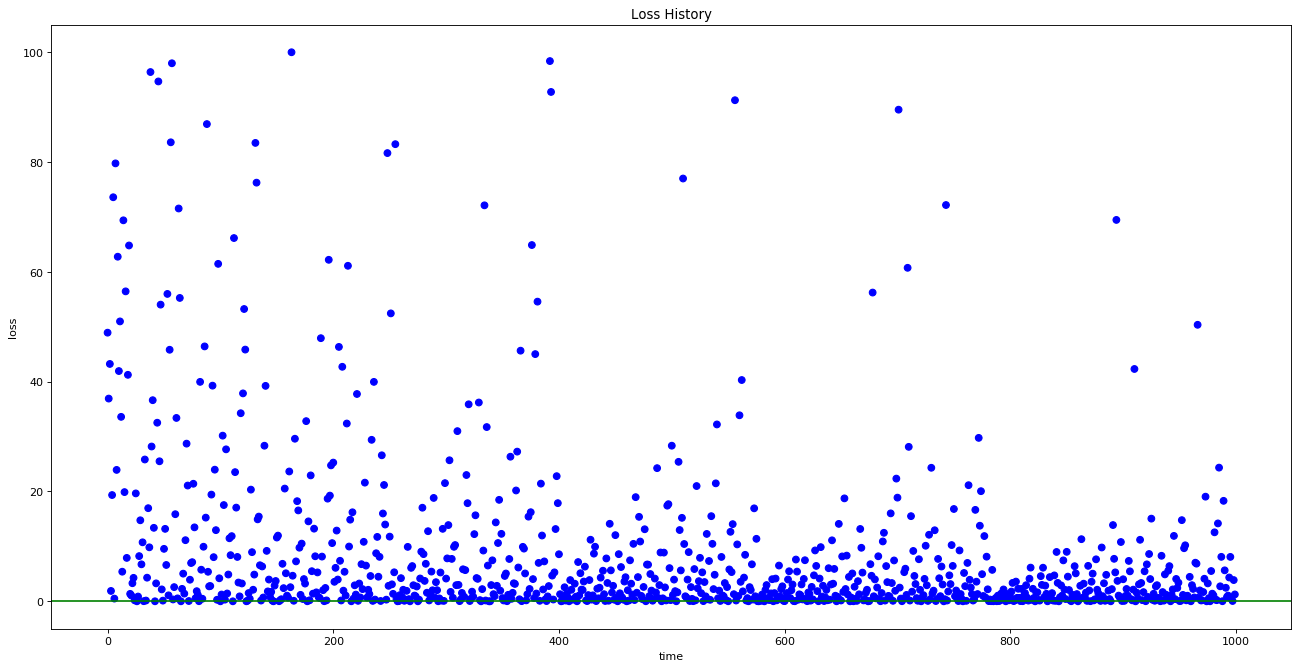

In [66]:


plt.figure(num=None, figsize=(20, 10), dpi=80)
main_plot_history(trials)

In [89]:
losses = [t['result']['loss'] for t in trials.trials]
range(len(losses))

range(0, 1000)

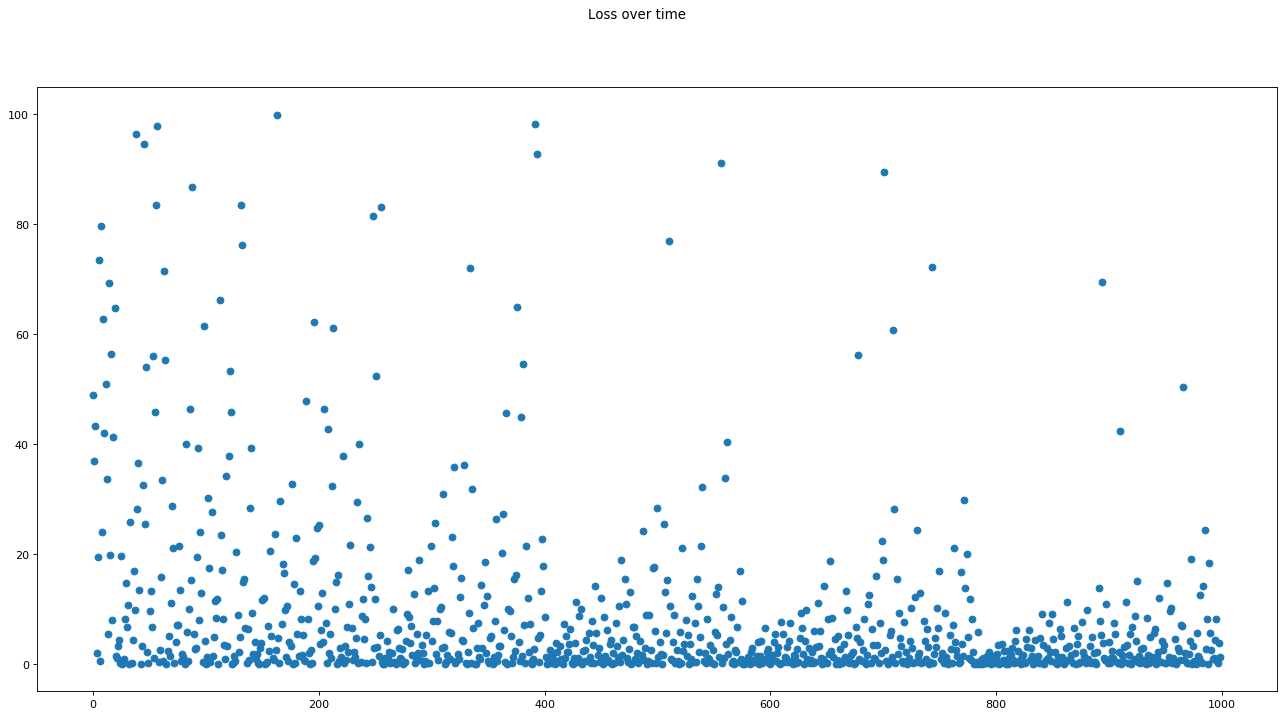

In [90]:
fig = plt.figure(num=None, figsize=(20, 10), dpi=80)
fig.suptitle('Loss over time')
plt.scatter(range(len(losses)), losses)
plt.show()

Showing Histogram of 1000 jobs


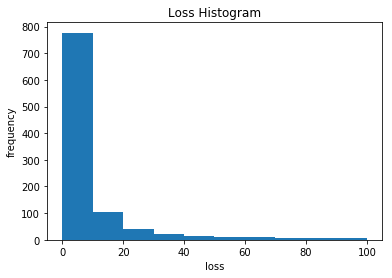

In [67]:
main_plot_histogram(trials)

finite loss range 1.054959777024095e-05 99.93805553559746 -0.9999894504022298


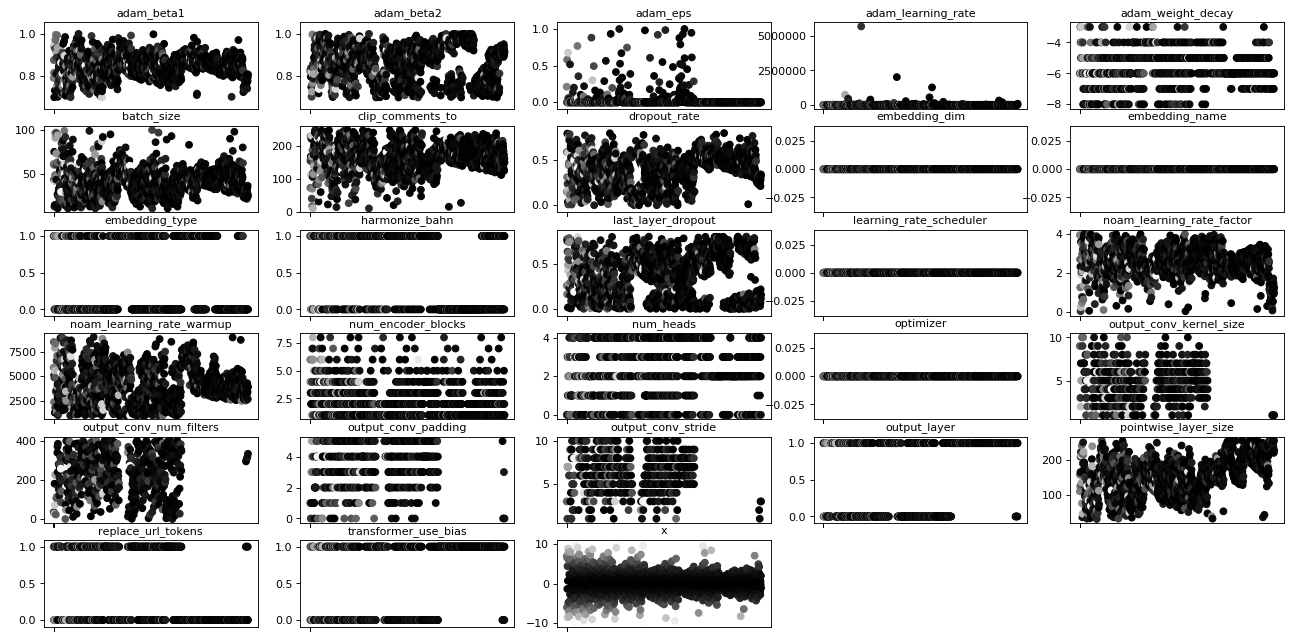

In [69]:
figure(num=None, figsize=(20, 10), dpi=80)
main_plot_vars(trials)